In [1]:
%load_ext jupyter_black

In [2]:
import os

import torch
import numpy as np

import mesoscaler as ms


_local_data = os.path.abspath("data")

urma_store = os.path.join(_local_data, "urma.zarr")
assert os.path.exists(urma_store)
era5_store = os.path.join(_local_data, "era5.zarr")
assert os.path.exists(era5_store)

from mesoscaler.enums import (
    # - ERA5
    GEOPOTENTIAL,
    SPECIFIC_HUMIDITY,
    TEMPERATURE,
    U_COMPONENT_OF_WIND,
    V_COMPONENT_OF_WIND,
    # - URMA
    SURFACE_PRESSURE,
    TEMPERATURE_2M,
    SPECIFIC_HUMIDITY_2M,
    U_WIND_COMPONENT_10M,
    V_WIND_COMPONENT_10M,
    SURFACE_PRESSURE,
)

era5_dvars = [
    GEOPOTENTIAL,
    TEMPERATURE,
    SPECIFIC_HUMIDITY,
    U_COMPONENT_OF_WIND,
    V_COMPONENT_OF_WIND,
]

urma_dvars = [
    SURFACE_PRESSURE,
    TEMPERATURE_2M,
    SPECIFIC_HUMIDITY_2M,
    U_WIND_COMPONENT_10M,
    V_WIND_COMPONENT_10M,
]

dataset_sequence = ms.open_datasets([(urma_store, urma_dvars), (era5_store, era5_dvars)])
dataset_sequence

DatasetSequence(size=2)[
<xarray.DependentDataset>
Dimensions:               (Y: 1597, X: 2345, T: 24, Z: 1)
Coordinates:
    latitude              (Y, X) float64 19.23 19.23 19.24 ... 54.38 54.38 54.37
    longitude             (Y, X) float64 233.7 233.7 233.8 ... 300.9 300.9 301.0
  * time                  (T) datetime64[ns] 2019-01-01T03:00:00 ... 2019-01-...
  * vertical              (Z) float64 1.013e+03
Dimensions without coordinates: Y, X, T, Z
Data variables:
    specific_humidity_2m  (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    surface_pressure      (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    temperature_2m        (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    u_wind_component_10m  (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    v_wind_component_10m  (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
Attributes:
    depends:  Dependencies(URMA)
<xarray.DependentDataset>
Dimensions:              (T: 25, Z: 23, Y: 721, X: 1440)
Coordinates:
    latitude             (Y, X) float32 90.0 90.0 90.0 ... -90.0 -90.0 -90.0
  * vertical             (Z) int64 200 225 250 300 350 ... 900 925 950 975 1000
    longitude            (Y, X) float32 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time                 (T) datetime64[ns] 2019-01-01 ... 2019-01-02
Dimensions without coordinates: T, Z, Y, X
Data variables:
    geopotential         (T, Z, Y, X) float32 dask.array<chunksize=(1, 23, 721, 1440), meta=np.ndarray>
    specific_humidity    (T, Z, Y, X) float32 dask.array<chunksize=(1, 23, 721, 1440), meta=np.ndarray>
    temperature          (T, Z, Y, X) float32 dask.array<chunksize=(1, 23, 721, 1440), meta=np.ndarray>
    u_component_of_wind  (T, Z, Y, X) float32 dask.array<chunksize=(1, 23, 721, 1440), meta=np.ndarray>
    v_component_of_wind  (T, Z, Y, X) float32 dask.array<chunksize=(1, 23, 721, 1440), meta=np.ndarray>
Attributes:
    depends:  Dependencies(ERA5)
]

In [ ]:
import dataclasses
from mesoscaler._typing import Pair


@dataclasses.dataclass
class Config:
    width: int
    height: int
    dx: int
    dy: int
    ratio: float
    frames: int = 1

    @classmethod
    def from_ratio(cls, img_size: int, distance: int, ratio: float):
        height = int(img_size / ratio)
        width = img_size
        dx = distance
        dy = int(dx / ratio)
        return cls(width, height, dx, dy, ratio)

    @property
    def image_size(self) -> Pair[int]:
        return (self.width, self.height)
    @property
    def patch_size(self):
        return (self.dx, self.dy)
    
    def _validate(self):
        img_size = self.image_size
        patch_size = self.patch_size
        assert img_size[1] % patch_size[1] == 0
        assert img_size[0] % patch_size[0] == 0
        assert frames % t_patch_size == 0

config = Config.from_ratio(80, 200, 2 / 1)
config._validate()

Config(width=80, height=40, dx=200, dy=100, ratio=2.0)

In [4]:
texas = -106.6, 25.8, -93.5, 36.5
loader = ms.create.loader(
    dataset_sequence,
    ms.AreaOfInterestSampler.partial(aoi=texas, time_batch_size=config.frames),
    batch_size=2,
    dx=config.dx,
    dy=config.dy,
    width=config.width,
    height=config.height,
)
b = next(iter(loader))
b.shape

torch.Size([2, 5, 4, 6, 40, 80])

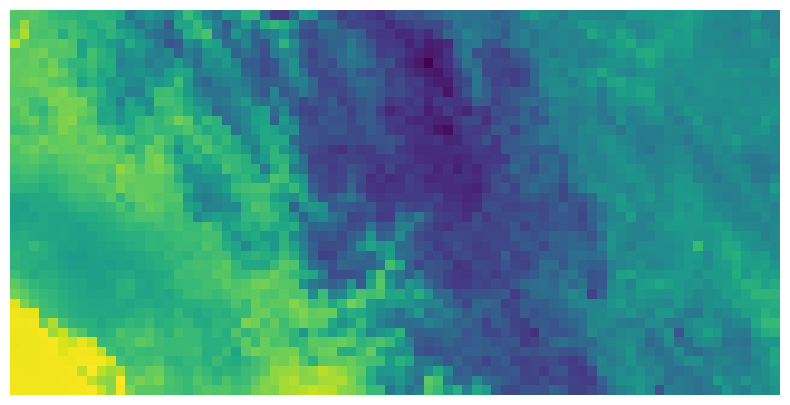

In [5]:
import matplotlib.pyplot as plt

shape = batch, data_var, time, level, lat, lon = 0, 2, -1, 0, slice(None), slice(None)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.imshow(b[batch, data_var, time, level, lat, lon])
ax.axis("off")
plt.show()

In [6]:
import functools
import itertools
import collections.abc
from typing import Callable, TypeVar, Sequence, Iterable
from typing import TypeAlias

import torch.nn as nn


_T = TypeVar("_T")

PairOr: TypeAlias = Pair[_T] | _T


def drop_path(
    x: torch.Tensor, drop_prob: float = 0.0, training: bool = False, scale_by_keep: bool = True
) -> torch.Tensor:
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.

    """
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)
    return x * random_tensor


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks)."""

    def __init__(self, drop_prob: float = 0.0, scale_by_keep: bool = True) -> None:
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)

    def extra_repr(self):
        return f"drop_prob={round(self.drop_prob,3):0.3f}"


class MultiLayerPerceptron(nn.Module):
    """MLP as used in Vision Transformer, MLP-Mixer and related networks

    A multilayer perceptron (MLP) is a misnomer for a modern feedforward artificial neural network, consisting of
    fully connected neurons with a nonlinear kind of activation function, organized in at least three layers, notable
    for being able to distinguish data that is not linearly separable.[1] It is a misnomer because the original
    perceptron used a Heaviside step function, instead of a nonlinear kind of activation function
    (used by modern networks).

    Modern feedforward networks are trained using the back-propagation and are colloquially referred to as the "vanilla" neural networks.
    """

    def __init__(
        self,
        in_features,
        hidden_features=None,
        out_features=None,
        act_layer=nn.GELU,
        norm_layer=None,
        bias: PairOr[bool] = True,
        drop: PairOr[float] = 0.0,
        use_conv=False,
    ) -> None:
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        bias = ms.pair(bias)
        drop_probs = ms.pair(drop)
        linear_layer = functools.partial(nn.Conv2d, kernel_size=1) if use_conv else nn.Linear

        self.fc1 = linear_layer(in_features, hidden_features, bias=bias[0])
        self.act = act_layer()
        self.drop1 = nn.Dropout(drop_probs[0])
        self.norm = norm_layer(hidden_features) if norm_layer is not None else nn.Identity()
        self.fc2 = linear_layer(hidden_features, out_features, bias=bias[1])
        self.drop2 = nn.Dropout(drop_probs[1])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.norm(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x


class PatchEmbed(nn.Module):
    """Image to Patch Embedding"""

    proj: Callable[[torch.Tensor], torch.Tensor]

    def __init__(
        self,
        img_size: PairOr[int] = 224,
        patch_size: PairOr[int] = 16,
        in_chans: int = 3,
        embed_dim: int = 768,
        # temporal related:
        frames: int = 32,
        t_patch_size: int = 4,
    ):
        super().__init__()
        img_size = ms.pair(img_size)
        patch_size = ms.pair(patch_size)
        assert img_size[1] % patch_size[1] == 0
        assert img_size[0] % patch_size[0] == 0
        assert frames % t_patch_size == 0
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0]) * (frames // t_patch_size)
        self.input_size = (
            frames // t_patch_size,
            img_size[0] // patch_size[0],
            img_size[1] // patch_size[1],
        )
        print(f"img_size {img_size} patch_size {patch_size} frames {frames} t_patch_size {t_patch_size}")
        self.img_size = img_size
        self.patch_size = patch_size

        self.frames = frames
        self.t_patch_size = t_patch_size

        self.num_patches = num_patches

        self.grid_size = img_size[0] // patch_size[0]
        self.t_grid_size = frames // t_patch_size

        kernel_size = (t_patch_size,) + patch_size  # [t_patch_size] + list(patch_size)
        self.proj = nn.Conv3d(in_chans, embed_dim, kernel_size=kernel_size, stride=kernel_size)  # type: ignore

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, T, H, W = x.shape
        assert (
            H == self.img_size[0] and W == self.img_size[1]
        ), f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        assert T == self.frames
        x = self.proj(x).flatten(3)
        x = torch.einsum("ncts->ntsc", x)  # [N, T, H*W, C]
        return x


class Attention(nn.Module):
    q: Callable[[torch.Tensor], torch.Tensor]
    k: Callable[[torch.Tensor], torch.Tensor]
    v: Callable[[torch.Tensor], torch.Tensor]

    def __init__(
        self,
        dim: int,
        num_heads: int = 8,
        qkv_bias=False,
        qk_scale=None,
        attn_drop: float = 0.0,
        proj_drop: float = 0.0,
        input_size: tuple[int, int, int] = (4, 14, 14),
    ) -> None:
        super().__init__()
        assert dim % num_heads == 0, "dim should be divisible by num_heads"
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.k = nn.Linear(dim, dim, bias=qkv_bias)
        self.v = nn.Linear(dim, dim, bias=qkv_bias)
        assert attn_drop == 0.0  # do not use
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.input_size = input_size
        assert input_size[1] == input_size[2]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        k = self.k(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        v = self.v(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        attn = (q @ k.transpose(-2, -1)) * self.scale

        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        x = x.view(B, -1, C)
        return x


class Block(nn.Module):
    """
    Transformer Block with specified Attention function
    """

    drop_path: Callable[[torch.Tensor], torch.Tensor]

    def __init__(
        self,
        dim: int,
        num_heads: int,
        mlp_ratio: float = 4.0,
        qkv_bias=False,
        qk_scale=None,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        drop_path: float = 0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
        attn_func=Attention,
    ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = attn_func(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop,
        )
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MultiLayerPerceptron(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=drop,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

In [7]:
class MaskedAutoencoderViT(nn.Module):
    __call__: Callable[[torch.Tensor], torch.Tensor]

    # img_size: PairOr[int] = 224,
    # patch_size: PairOr[int] = 16,
    def __init__(
        self,
        img_size: PairOr[int] = 224,
        patch_size: PairOr[int] = 16,
        in_chans: int = 3,
        embed_dim: int = 1024,
        depth: int = 24,
        num_heads: int = 16,
        decoder_embed_dim: int = 512,
        decoder_depth: int = 8,
        decoder_num_heads: int = 16,
        mlp_ratio: float = 4.0,
        norm_layer=nn.LayerNorm,
        norm_pix_loss: bool = False,
        num_frames=16,
        t_patch_size=4,
        patch_embed: type[PatchEmbed] | None = None,
        no_qkv_bias=False,
        sep_pos_embed=False,
        trunc_init=False,
        cls_embed=False,
        pred_t_dim=8,
        # **kwargs,
    ):
        super().__init__()
        self.trunc_init = trunc_init
        self.sep_pos_embed = sep_pos_embed
        self.cls_embed = cls_embed
        self.pred_t_dim = pred_t_dim
        self.t_pred_patch_size = t_patch_size * pred_t_dim // num_frames

        self.patch_embed = PatchEmbed(
            img_size,
            patch_size,
            in_chans,
            embed_dim,
            num_frames,
            t_patch_size,
        )
        num_patches = self.patch_embed.num_patches
        input_size = self.patch_embed.input_size
        self.input_size = input_size

        if self.cls_embed:
            self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
            self.decoder_cls_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        if sep_pos_embed:
            self.pos_embed_spatial = nn.Parameter(torch.zeros(1, input_size[1] * input_size[2], embed_dim))
            self.pos_embed_temporal = nn.Parameter(torch.zeros(1, input_size[0], embed_dim))
            if self.cls_embed:
                self.pos_embed_class = nn.Parameter(torch.zeros(1, 1, embed_dim))
        else:
            if self.cls_embed:
                _num_patches = num_patches + 1
            else:
                _num_patches = num_patches

            self.pos_embed = nn.Parameter(
                torch.zeros(1, _num_patches, embed_dim),
            )

        self.blocks = nn.ModuleList(
            [
                Block(
                    embed_dim,
                    num_heads,
                    mlp_ratio,
                    qkv_bias=not no_qkv_bias,
                    qk_scale=None,
                    norm_layer=norm_layer,
                )
                for i in range(depth)
            ]
        )
        self.norm = norm_layer(embed_dim)

        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        if sep_pos_embed:
            self.decoder_pos_embed_spatial = nn.Parameter(
                torch.zeros(1, input_size[1] * input_size[2], decoder_embed_dim)
            )
            self.decoder_pos_embed_temporal = nn.Parameter(torch.zeros(1, input_size[0], decoder_embed_dim))
            if self.cls_embed:
                self.decoder_pos_embed_class = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
        else:
            if self.cls_embed:
                _num_patches = num_patches + 1
            else:
                _num_patches = num_patches

            self.decoder_pos_embed = nn.Parameter(
                torch.zeros(1, _num_patches, decoder_embed_dim),
            )

        self.decoder_blocks = nn.ModuleList(
            [
                Block(
                    decoder_embed_dim,
                    decoder_num_heads,
                    mlp_ratio,
                    qkv_bias=not no_qkv_bias,
                    qk_scale=None,
                    norm_layer=norm_layer,
                )
                for i in range(decoder_depth)
            ]
        )

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(
            decoder_embed_dim,
            self.t_pred_patch_size * patch_size**2 * in_chans,
            bias=True,
        )

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

        print("model initialized")

    def initialize_weights(self) -> None:
        if self.cls_embed:
            torch.nn.init.trunc_normal_(self.cls_token, std=0.02)
        if self.sep_pos_embed:
            torch.nn.init.trunc_normal_(self.pos_embed_spatial, std=0.02)
            torch.nn.init.trunc_normal_(self.pos_embed_temporal, std=0.02)

            torch.nn.init.trunc_normal_(self.decoder_pos_embed_spatial, std=0.02)
            torch.nn.init.trunc_normal_(self.decoder_pos_embed_temporal, std=0.02)

            if self.cls_embed:
                torch.nn.init.trunc_normal_(self.pos_embed_class, std=0.02)
                torch.nn.init.trunc_normal_(self.decoder_pos_embed_class, std=0.02)
        else:
            torch.nn.init.trunc_normal_(self.pos_embed, std=0.02)
            torch.nn.init.trunc_normal_(self.decoder_pos_embed, std=0.02)
        w = self.patch_embed.proj.weight.data
        if self.trunc_init:
            torch.nn.init.trunc_normal_(w)
            torch.nn.init.trunc_normal_(self.mask_token, std=0.02)
        else:
            torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
            torch.nn.init.normal_(self.mask_token, std=0.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m: nn.Module) -> None:
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            if self.trunc_init:
                nn.init.trunc_normal_(m.weight, std=0.02)
            else:
                torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x


model = MaskedAutoencoderViT(
    img_size=config.image_size,
)
model

AssertionError: 